In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.model_selection import KFold

# <U>Setup the data</U>

In [2]:
#Load the data
data = pd.read_csv("../data/german_credit_data/german.data", sep=" ", header = None)
data.columns = ['account_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_account_or_bonds',
                'present_employment_since', 'installment_rate', 'personal_status_and_sex', 'other_debtors_or_guarantors',
                'present_residence_since', 'property', 'age', 'other_installment_plans', 'housing', 
                'number_of_exisiting_credits', 'job', 'number_of_people_liable_for_maintenance', 'telephone', 'foreign_worker',
                'class']

In [3]:
#le = preprocessing.LabelEncoder()
#le.fit(["paris", "paris", "tokyo", "amsterdam"])
#le.transform(["tokyo", "tokyo", "paris"]) 
#data['account_status']

In [4]:
#Transform any categorical values
le = preprocessing.LabelEncoder()
data = data.apply(le.fit_transform)
data

,account_status,duration,credit_history,purpose,credit_amount,savings_account_or_bonds,present_employment_since,installment_rate,personal_status_and_sex,other_debtors_or_guarantors,...,property,age,other_installment_plans,housing,number_of_exisiting_credits,job,number_of_people_liable_for_maintenance,telephone,foreign_worker,class
0,0,2,4,4,142,4,4,3,2,0,...,0,48,2,1,1,2,0,1,0,0
1,1,29,2,4,770,0,2,1,1,0,...,0,3,2,1,0,2,0,0,0,1
2,3,8,4,7,390,0,3,1,2,0,...,0,30,2,1,0,1,1,0,0,0
3,0,26,2,3,848,0,3,1,2,2,...,1,26,2,2,0,2,1,0,0,0
4,0,17,3,0,734,0,2,2,2,0,...,3,34,2,2,1,2,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,8,2,3,310,0,3,2,1,0,...,0,12,2,1,0,1,0,0,0,0
996,0,21,2,1,661,0,2,3,0,0,...,1,21,2,1,0,3,0,1,0,0
997,3,8,2,4,69,0,4,3,2,0,...,2,19,2,1,0,2,0,0,0,0
998,0,27,2,4,332,0,2,3,2,0,...,3,4,2,2,0,2,0,1,0,1


In [5]:
#Get a subset of the data
sub_data = data[['credit_amount', 'duration', 'age', 'class']]
sub_data

,credit_amount,duration,age,class
0,142,2,48,0
1,770,29,3,1
2,390,8,30,0
3,848,26,26,0
4,734,17,34,1
...,...,...,...,...
995,310,8,12,0
996,661,21,21,0
997,69,8,19,0
998,332,27,4,1


# <U>Part 1 (Impurity Measure = Gini):</U>

### Build a decision tree model

In [6]:
#Apply Decision Tree Classifier
def decision_tree_classifier(sub_data, impurity_measure, tree_depth, show_plot=True):
    Y = sub_data['class']
    X = sub_data.drop(['class'], axis=1)

    clf = tree.DecisionTreeClassifier(criterion=impurity_measure, max_depth=tree_depth)
    clf = clf.fit(X, Y)
    
    if show_plot:
        fn=['credit_amount', 'duration', 'age']
        cn=['1', '2']
        fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), dpi=1500)
        tree.plot_tree(clf,
                       feature_names = fn, 
                       class_names=cn,
                       filled = True);
    return clf

In [7]:
clf = decision_tree_classifier(sub_data, 'gini', 4, True)

### Compute Holdout

In [8]:
#Perform holdout
def holdout(sub_data, impurity_measure, tree_depth, is_test):
    #Split data in train and test
    train_data = sub_data.sample(frac = 0.9)
    test_data = sub_data.drop(train_data.index)
    
    #Apply Decision Tree Classifier to train_data
    clf = decision_tree_classifier(train_data, impurity_measure, tree_depth, False)
    
    if (is_test):
        #Apply Decision Tree Classifier to test_data
        testY = test_data['class']
        testX = test_data.drop(['class'],axis=1)

        predY = clf.predict(testX)
        predictions = pd.DataFrame(predY, columns = ['Predicted Class'])
        #print(predictions)

        #Compute Accuracy, Precision, F-measure
        accuracy = accuracy_score(testY, predY)
        precision = precision_score(testY, predY)
        f_measure =  f1_score(testY, predY)
        
    else:
        #Apply Decision Tree Classifier to train_data
        trainY = train_data['class']
        trainX = train_data.drop(['class'],axis=1)

        predY = clf.predict(trainX)
        predictions = pd.DataFrame(predY, columns = ['Predicted Class'])
        #print(predictions)

        #Compute Accuracy, Precision, F-measure
        accuracy = accuracy_score(trainY, predY)
        precision = precision_score(trainY, predY)
        f_measure =  f1_score(trainY, predY)

    return [round(accuracy, 2), round(precision, 2), round(f_measure, 2)]

In [9]:
#Perform holdout 5 times
def holdout_x5(sub_data, impurity_measure, tree_depth, is_test):
    accuracy_list = ['accuracy']
    precision_list = ['precision']
    f_measure_list = ['f_measure']

    for x in range(5):
        metrics = holdout(sub_data, impurity_measure, tree_depth, is_test)
        #print(metrics)
        accuracy_list.append(metrics[0])
        precision_list.append(metrics[1])
        f_measure_list.append(metrics[2])

    avg_accuracy = round(np.mean(accuracy_list[1:]), 2)
    avg_precision = round(np.mean(precision_list[1:]), 2)
    avg_f_measure = round(np.mean(f_measure_list[1:]), 2)

    accuracy_list.append(avg_accuracy)
    precision_list.append(avg_precision)
    f_measure_list.append(avg_f_measure)

    #print(accuracy_list)
    #print(precision_list)
    #print(f_measure_list)

    metrics_data = pd.DataFrame([accuracy_list, precision_list, f_measure_list],
                               columns=['metric', 'trial #1', 'trial #2', 'trial #3', 'trial #4', 'trial #5', 'average'])
    return metrics_data

holdout_x5(sub_data, 'gini', 4, True)

,metric,trial #1,trial #2,trial #3,trial #4,trial #5,average
0,accuracy,0.71,0.72,0.71,0.80,0.72,0.73
1,precision,0.67,0.33,1.00,0.67,0.62,0.66
2,f_measure,0.29,0.22,0.17,0.38,0.26,0.26


### Compute Cross-validation

In [10]:
#Perform cross-validation
def cross_validation(sub_data, impurity_measure):
    accuracy_list = ['accuracy']
    precision_list = ['precision']
    f_measure_list = ['f_measure']
    
    kf = KFold(n_splits=10)
    #Split data in train and test
    for train, test in kf.split(sub_data):
        train_data = sub_data.loc[train]
        test_data = sub_data.loc[test]
        
        #Apply Decision Tree Classifier to train_data
        clf = decision_tree_classifier(train_data, impurity_measure, 4, False)

        #Apply Decision Tree Classifier to test_data
        testY = test_data['class']
        testX = test_data.drop(['class'],axis=1)

        predY = clf.predict(testX)
        predictions = pd.DataFrame(predY, columns = ['Predicted Class'])
        #print(predictions)

        #Compute Accuracy, Precision, F-measure
        accuracy = accuracy_score(testY, predY)
        precision = precision_score(testY, predY)
        f_measure =  f1_score(testY, predY)        

        metrics = [round(accuracy, 2), round(precision, 2), round(f_measure, 2)]
        
        accuracy_list.append(metrics[0])
        precision_list.append(metrics[1])
        f_measure_list.append(metrics[2])

    avg_accuracy = round(np.mean(accuracy_list[1:]), 2)
    avg_precision = round(np.mean(precision_list[1:]), 2)
    avg_f_measure = round(np.mean(f_measure_list[1:]), 2)

    accuracy_list.append(avg_accuracy)
    precision_list.append(avg_precision)
    f_measure_list.append(avg_f_measure)
    
    metrics_data = pd.DataFrame([accuracy_list, precision_list, f_measure_list],
                           columns=['metric', 'trial #1', 'trial #2', 'trial #3', 'trial #4', 'trial #5', 'trial #6', 'trial #7', 'trial #8', 'trial #9', 'trial #10', 'average'])
        
    return metrics_data
    
gini_cross_validation = cross_validation(sub_data, 'gini')
gini_cross_validation

,metric,trial #1,trial #2,trial #3,trial #4,trial #5,trial #6,trial #7,trial #8,trial #9,trial #10,average
0,accuracy,0.75,0.65,0.76,0.74,0.74,0.61,0.68,0.70,0.66,0.68,0.70
1,precision,0.50,0.33,0.45,0.57,1.00,1.00,0.33,0.62,0.27,0.50,0.56
2,f_measure,0.32,0.15,0.29,0.38,0.13,0.09,0.11,0.25,0.15,0.16,0.20


# <U>Part 2 (Impurity Measure = Entropy)<U>

In [11]:
#Perform holdout 5 times
holdout_x5(sub_data, 'entropy', 4, True)

,metric,trial #1,trial #2,trial #3,trial #4,trial #5,average
0,accuracy,0.67,0.68,0.77,0.69,0.74,0.71
1,precision,0.36,0.45,0.50,0.48,0.75,0.51
2,f_measure,0.20,0.24,0.21,0.46,0.19,0.26


In [12]:
#Perform cross-validation
entropy_cross_validation = cross_validation(sub_data, 'entropy')
entropy_cross_validation

,metric,trial #1,trial #2,trial #3,trial #4,trial #5,trial #6,trial #7,trial #8,trial #9,trial #10,average
0,accuracy,0.75,0.66,0.75,0.74,0.70,0.61,0.65,0.71,0.74,0.68,0.70
1,precision,0.50,0.38,0.42,0.57,0.25,1.00,0.22,0.67,1.00,0.50,0.55
2,f_measure,0.32,0.15,0.29,0.38,0.06,0.09,0.10,0.29,0.19,0.16,0.20


In [13]:
#Select accuracies
gini_cross_validation_accuracy = gini_cross_validation['average'][0]
entropy_cross_validation_accuracy  = entropy_cross_validation['average'][0]
#print(gini_cross_validation_accuracy)
#print(entropy_cross_validation_accuracy)

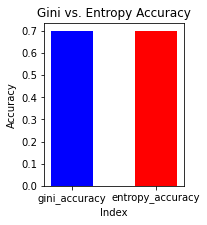

In [14]:
accuracy_labels = ["gini_accuracy", "entropy_accuracy"]
accuracy_values = [gini_cross_validation_accuracy, entropy_cross_validation_accuracy]

#Create the bar plot
plt.figure(figsize=(2.5,3))
plt.bar(accuracy_labels, accuracy_values, color =['blue', 'red'], width = 0.5)
plt.title("Gini vs. Entropy Accuracy") 
plt.xlabel("Index") 
plt.ylabel("Accuracy") 
plt.show() 

# <U>Part 3 - Tree Depth Investigation<U>

In [17]:
tree_depths = np.arange(2, 51, 3)
train_y = []
test_y = []
for tree_depth in range (2, 51, 3):
    gini_holdout_accuracy_train = holdout_x5(sub_data, 'gini', tree_depth, False)['average'][0]
    gini_holdout_accuracy_test = holdout_x5(sub_data, 'gini', tree_depth, True)['average'][0]
    train_y.append(gini_holdout_accuracy_train)
    test_y.append(gini_holdout_accuracy_test)
print(train_y)
print(test_y)

[0.73, 0.75, 0.81, 0.88, 0.95, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.68, 0.73, 0.67, 0.67, 0.64, 0.63, 0.66, 0.62, 0.6, 0.62, 0.64, 0.64, 0.67, 0.64, 0.6, 0.62, 0.63]


Text(0, 0.5, 'Accuracy')

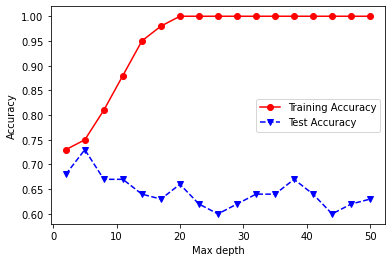

In [18]:
#Plot the tree-depth accuracies
plt.plot(tree_depths, train_y, 'ro-', tree_depths, test_y, 'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

### Observations:
The plot above shows that training accuracy will continue to improve as the maximum depth of the tree increases (i.e., as the model becomes more complex). The training accuracy reaches at 100% at around a maximum depth of 20. However, the test accuracy initially improves up to a maximum depth of 5, before it gradually decreases due to model becoming too complex and overfitting.